In [1]:
#Import relevant packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pickle #To unpack the file
import matplotlib.pyplot as plt #For plotting
import torch.optim as optim #Parameter optimization functions
from torch.utils.data import Dataset, DataLoader, ConcatDataset #Creating the Dataset and DataLoader
import torchvision
import torchvision.transforms as transforms #Scaling

In [16]:
#Check GPU status
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Create the dataLoader class

The data is pickled which means that the objects are converted into a byte stream. We will unpickle the object to get back the original data. (https://www.cs.toronto.edu/~kriz/cifar.html). Below is the Dataset class which can be used in torch.utils.data.dataLoader

In [2]:
class cifarDataset(Dataset):
    def __init__(self, filePath, transform=None):
        self.images, self.labels = self.__loadImages__(filePath)
        self.transform = transform

    def __loadImages__(self, filePath):
        object = self.__unpickle__(filePath) #Extract our dataset
        X = object[b'data']
        X = X.reshape(len(object[b'data']),3,32,32) #Reshape to Color and the corresponding XY coordinates
        l = object[b'labels']
        return(X,l)
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx]
        #print("Before permute", image.shape)
        image = np.transpose(image, (1,2,0)) #Permute because transforms.ToTensor converts HWC to CHW
        #print("After permute", image.shape )
        image = transforms.ToTensor()(image)
        #print("ToTensor", image.shape)
        #print("Before", image)
        image = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(image) #Normalize our image
        #print("After", image)
        sample = {'image':image, 'label':self.labels[idx]}
        return(sample)
        
    def __unpickle__(self, file):
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict
        

In [3]:
def showImage(img, label='Not labeled'):
    img = img / 2 + 0.5     # unnormalize
    img = img.permute(1,2,0)
    plt.imshow(img)
    plt.xlabel(label)
    plt.show()

In [4]:
def getLabel(number):
    names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    return(names[number])

## Load the dataset

In [5]:
batch1 = cifarDataset(filePath='data/cifar-10-batches-py/data_batch_1')
batch2 = cifarDataset(filePath='data/cifar-10-batches-py/data_batch_2')
batch3 = cifarDataset(filePath='data/cifar-10-batches-py/data_batch_3')
batch4 = cifarDataset(filePath='data/cifar-10-batches-py/data_batch_4')
batch5 = cifarDataset(filePath='data/cifar-10-batches-py/data_batch_5')

In [6]:
#Concatenate our training dataset
batches = torch.utils.data.ConcatDataset([batch1,batch2, batch3, batch4, batch5])

In [7]:
#Use the dataLoader to extract images from our dataset
trainloader = DataLoader(batches, batch_size=5, shuffle=True, num_workers=4)

In [8]:
testBatch = cifarDataset(filePath='data/cifar-10-batches-py/test_batch')
#Create the dataLoader for our test set
testloader = DataLoader(testBatch, batch_size=1, shuffle=True, num_workers=4)

Batch information:  0 torch.Size([5, 3, 32, 32]) tensor([5, 1, 8, 4, 5])


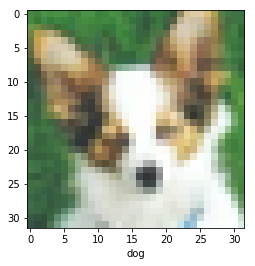

In [9]:
#Try using the dataloader to print one image
for i_batch, sample_batched in enumerate(trainloader):
    print("Batch information: ", i_batch, sample_batched['image'].size(), sample_batched['label'])
    showImage(sample_batched['image'][0],getLabel(sample_batched['label'][0]))
    break

## Create a CNN model

In [10]:
#Define the neural net.
class CNN(nn.Module):
    
    def __init__(self):
        #Define the network
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 8, 5) #We have 3 channels. Output 6 feature map with 5x5 kernel
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(8, 20, 5) #We have 6 channels. Output 20 feature map with 5x5 kernel
        self.fc1 = nn.Linear(20 * 5 * 5, 60)
        self.fc2 = nn.Linear(60, 10)
        
        # Adding a layer for LogSoftmax to obtain log probabilities
        # As recommended in documentation for Negative log likelihood loss https://pytorch.org/docs/stable/nn.html#nllloss
        self.logsoftmax = nn.LogSoftmax(dim=1) 

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 20 * 5 * 5)
        x = self.fc1(x)
        x = self.logsoftmax(self.fc2(x))
        return(x)


## Train the network

In [17]:
#Initialize the neural net
classifier = CNN()
classifier.to(device)
print(classifier)
#Create the optim
optimizer = optim.SGD(classifier.parameters(), lr=0.005, momentum=0.8)

CNN(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=500, out_features=60, bias=True)
  (fc2): Linear(in_features=60, out_features=10, bias=True)
  (logsoftmax): LogSoftmax()
)


In [20]:
LossCount = []
for epoch in range(10):
    #Load batches from our trainLoader
    LossAggregate = 0
    for i_batch, sample_batched in enumerate(trainloader):
        
        #Get our data
        image = sample_batched['image']
        label = sample_batched['label']
        image, label = image.to(device), label.to(device)
        # zero the gradient of optimizer
        optimizer.zero_grad()
        
        # forward pass
        output = classifier(image)
        # Use Negative Likelihood Loss
        loss = nn.NLLLoss()(output, label)
        
        #Record stats for every 100. Print average loss.
        LossAggregate += loss.item()
        if i_batch % 5000 == 4999: # print every 5000 batches (25000 images) 
            print('Epoch: %d. Minibatches %d loss %.3f' % (epoch + 1, i_batch+1, LossAggregate / 5000))
            LossCount.append(LossAggregate/5000)
            LossAggregate = 0.0
            
        #Propagate our losses
        loss.backward()
        optimizer.step()

KeyboardInterrupt: 

## Evaluate the accuracy

In [ ]:
correct = 0
total = 0
with torch.no_grad():
    for i_batch, sample_batched in enumerate(testloader):

        #Get our data
        image = sample_batched['image']
        label = sample_batched['label']
        #Foward pass
        output = classifier(image.type('torch.FloatTensor'))
        value = torch.max(output.data,1)[1]
        total += 1
        if value == label:
            correct += 1
print('Accuracy on our 10000 test set is %d percent' % (100 * correct/total))